## run notebooks

In [11]:
%run "initialization.ipynb"
%run "Input_selection_functions.ipynb"
%run "Downsampling_and_outliers_functions.ipynb"
%run "Stitching_clean.ipynb"
%run "Visualization_functions.ipynb"
%run "Evaluation_functions.ipynb"

%load_ext autoreload

----------------------------------------
loaded variables from initialization file: 
> myparams, myconfiguration_file
> list_picked_id_source, list_picked_id_target
> data_folder
----------------------------------------
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### just some handpicked visualization settings for this page

they are fed in "custom_draw_geometry" as for params, ad myconfiguration. 
if you dont want to use them just comment these lines out.

In [12]:
specific_screen, specific_render = specific_visualization_parameters("2Stitch")

loaded visualization options
- ../data/2StitchScreenCamera.json 
- ../data/2StitchRenderOption.json


## Load the pointclouds

In [13]:
# default
all_paths_images,all_paths_ply, num_images,labels,img_folder,ply_folder,all_images,all_ply = load_input(data_folder)

default set:
-imgfolder, contains 30 images 
-plyfolder_1, contains 30 ply  
['imgfolder', 'plyfolder_1']
found labels file: 
['External', 'Internal', 'Upper']


In [11]:
## uncomment following line to select different ply and img folders as input
#all_paths_images,all_paths_ply,num_images,labels,img_folder,ply_folder,,all_images,all_ply = select_input_files(data_folder)

In [4]:
all_seq_pcd = all_files_containing("initial_stitched_seq", extension = ".pcd")

# take most recent 3
all_seq_pcd = sorted(all_seq_pcd[-3:])
print (*all_seq_pcd, sep= "\n")

../data/initial_stitched_seq_0.pcd
../data/initial_stitched_seq_1.pcd
../data/initial_stitched_seq_2.pcd


In [5]:
list_stitches = [o3d.io.read_point_cloud(this_seq) for this_seq in all_seq_pcd]
labels_stitches = ["stitched_%s"%thislab for thislab in labels]
color_stitches = [[1, 0.706, 0],[0, 0.651, 0.929],[0,0.7,0.3]]

## Many plots

Just a visualization, rememeber you can close the windows by pressing Q.

In [6]:
# plot a list of geometries, dynamic
custom_draw_geometry([list_stitches],
                     mytitle = [labels_stitches],
                     #params = myparams,  
                     #configuration_file = myconfiguration_file, 
                     take_screen_shot = False,
                     rotate = True)

[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [7]:
labels_stitches

['stitched_External', 'stitched_Internal', 'stitched_Upper']

## Observation

The upper sequence looks like having more areas in common with the external and the internal than internal and external sequences have between themselves. It looks like a reasonable approach to start by stitching the upper sequence with one of the others.

## stitching 1 and 2

In [14]:
i = 1
j = 2

source_label = labels_stitches[i][9:] # just labels parsing
target_label =labels_stitches[j][9:]
source = list_stitches[i]
target = list_stitches[j]

start = timer()
new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= [source_label,target_label],

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 50000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**7,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.5,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = True,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

end = timer()

print ("duration:",(end-start))

stitch_Internal_Upper

DOWNSAMPLING BIG CLOUDS

Internal
Downsampling Internal from 227230 points with voxel size 0.1 
Downsampling Internal from 82782 points with voxel size 0.15 
Processed Internal has 42634 points 

Upper
Downsampling Upper from 219648 points with voxel size 0.1 
Downsampling Upper from 80867 points with voxel size 0.15 
Processed Upper has 45451 points 

DATA PREPARATION
removing outliers
value to reach:  109824.0
source has 227230 points
target has 219648 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=4.475309e-02, inlier_rmse=2.100964e-01, and correspondence_set size of 319
Access transformation to get result.
Transformation is:
[[  0.98987659  -0.05505795   0.13081649  -8.10084691]
 [ -0.02908819   0.82342972   0.56667219 -28.11384822]
 [ -0.138918    -0.56474075   0.81349227  12.37117841]
 

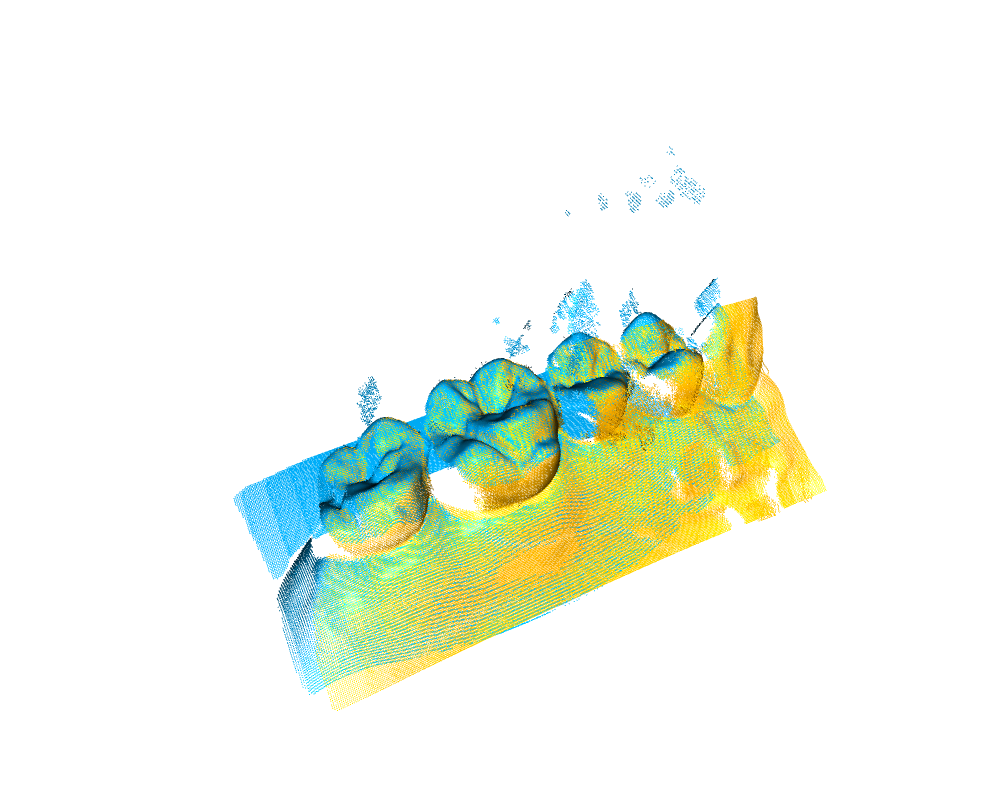

In [15]:
#o3d.visualization.draw_geometries([list_new_pointclouds[-1]])
stitched_seq_1_2 = newpointcloud
results_stitching_1_2 = all_results
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_1_2,
                     mytitle = tstring+ "stitched_seq_1_2",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

# after manual changing in visualization mode

newest = last_file_containing("stitched_seq_1_2", extension = '.png')
Im(filename=newest,width = 800)

### check on various attempt to get a good stitch

In [16]:
for k,v in results_stitching_1_2.items():
    print (f"\n{k}{dash}")
    print (f" GLOBAL: \n  fitness: {v[0].fitness} \n  inlier_rmse: {v[0].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[0].correspondence_set))}")
    print (f" ICP: \n  fitness: {v[1].fitness} \n  inlier_rmse: {v[1].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[1].correspondence_set))}")


1--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.044753086419753084 
  inlier_rmse: 0.21009643154737045 
  correspondence_set: 319
 ICP: 
  fitness: 0.8369581481318488 
  inlier_rmse: 0.09113060330845929 
  correspondence_set: 190182


Ok in this case our quality condition has been fullfilled at the first attempt, so not much to plot.

## stitching 0 to 1_2

this is the first approach, stitching the third sequence of point clouds.
* how hard is it? 
* how long does it take? 
* is the result acceptable? 

Note that the max number of attempt set to 100 is to retrieve the behaviour of the parameters. **DO NOT RE RUN NEXT CELL if you dont want to wait for quite sometime :)**

If you want to rerun, just set "reruncell" to True.

Also the results might vary at times, but the statistics at the end stand valid.

If this process wont be successfull a possible alternative: stitch 0 to 2 and than 0_2 to 1_2

In [17]:
reruncell = True
if reruncell == True:
    i = 0
    #j = 2

    target_label = labels_stitches[i][9:] # just labels parsing
    source_label = "stitched_seq_1_2"
    target = list_stitches[i]
    source = stitched_seq_1_2

    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                        #input 
                                                                        source = source, 
                                                                        target = target, 
                                                                        labels= [source_label,target_label],

                                                                        #downsampling 
                                                                        downsampling_voxel_size = 0.1,
                                                                        limit_size_point_cloud = 50000,

                                                                        #registration
                                                                        voxel_size = 0.2,
                                                                        mmax_iteration = 10**7,
                                                                        mmax_validation = 0.7,

                                                                        #icp registration
                                                                        icp_max_iteration = 1,
                                                                        
                                                                        # quality control of the stitching
                                                                        myoverlapping_factor = 0.5,
                                                                        maxnumattempts = 10,

                                                                        # visualization and pringtng parameters
                                                                        trans_init = None, # keep the possibility of starting directly the ICP
                                                                        print_statements = True,
                                                                        save_statements = False,
                                                                        visualization_on = False,
                                                                        final_vis_on = True,
                                                                        params = myparams,  
                                                                        configuration_file = myconfiguration_file
                                                                     )

stitch_stitched_seq_1_2_External

DOWNSAMPLING BIG CLOUDS

stitched_seq_1_2
Downsampling stitched_seq_1_2 from 446878 points with voxel size 0.1 
Downsampling stitched_seq_1_2 from 131856 points with voxel size 0.15 
Downsampling stitched_seq_1_2 from 68238 points with voxel size 0.2 
Processed stitched_seq_1_2 has 40230 points 

External
Downsampling External from 230502 points with voxel size 0.1 
Downsampling External from 92364 points with voxel size 0.15 
Downsampling External from 54486 points with voxel size 0.2 
Processed External has 33072 points 

DATA PREPARATION
removing outliers
value to reach:  115251.0
source has 446878 points
target has 230502 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=5.725191e-03, inlier_rmse=2.039108e-01, and correspondence_set size of 42
Access transformation to get result.


RegistrationResult with fitness=1.893336e-01, inlier_rmse=1.814584e-01, and correspondence_set size of 84609
Access transformation to get result.
Transformation is:
[[ 9.86609828e-01 -2.23700479e-02  1.61556887e-01 -7.51687999e+00]
 [-4.49869561e-02  9.14798132e-01  4.01398246e-01 -2.46147179e+01]
 [-1.56771236e-01 -4.03291407e-01  9.01542467e-01  7.53320484e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True


We can see how the targeted amount of overlapping is not achieved in the first 20 attempts. 
Now we will observe the "optimal" result achieved after 20 attempts.

The "optimal" result is determined by the number of pointclouds overlapping and this might not always be the best evaluation of the quality of the stitching. 

Then we study how much these fitting parameters vary, because it might well be that the overlapping that we expected to have, namely 0.5 % of the target, it is in this case just too high. 

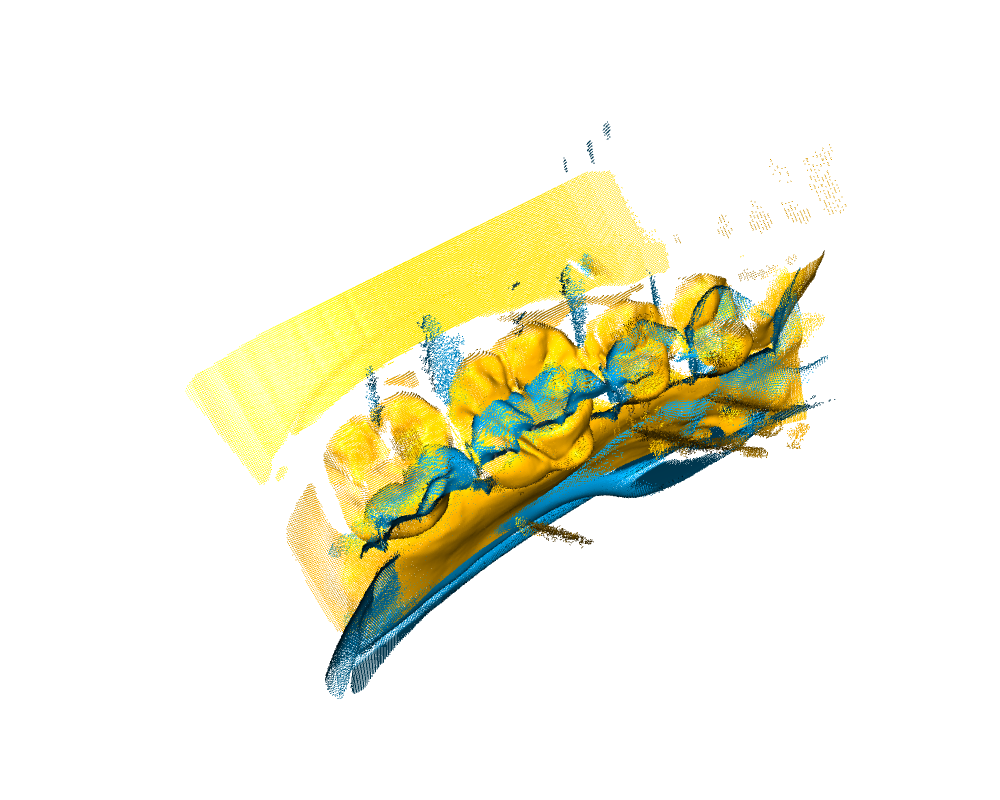

In [18]:
## lets visualize the "best transformation" as per number of overlapping points
tstring = mytimestamp()
custom_draw_geometry(newpointcloud,
                     mytitle = tstring+"wrongly_stitched_seq_0_12",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

# after manual changing in visualization mode
# selecting a specific one to show the point
newest = last_file_containing("wrongly_stitched_seq_0_12", extension = '.png')
Im(filename=newest,width = 800)

In [19]:
index_best_attempt,best_registration_icp,best_transformation,list_all_results_ordered= extract_best_result_and_transformation(all_results)
index_best_attempt

10

So, the "optimal" in terms of number of overlapping points is not really good...

## Evaluation of registration parameters

In [21]:
for k,v in all_results.items():
    print (f"\n{k}{dash}")
    print (f" GLOBAL: \n  {v[0]} ")
    print (f" ICP: \n {v[1]} ")
    #print (f" GLOBAL: \n  fitness: {v[0].fitness} \n  inlier_rmse: {v[0].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[0].correspondence_set))}")
    #print (f" ICP: \n  fitness: {v[1].fitness} \n  inlier_rmse: {v[1].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[1].correspondence_set))}")


1--------------------------------------------------------------------------------
 GLOBAL: 
  RegistrationResult with fitness=5.725191e-03, inlier_rmse=2.039108e-01, and correspondence_set size of 42
Access transformation to get result. 
 ICP: 
 RegistrationResult with fitness=1.762338e-01, inlier_rmse=1.962752e-01, and correspondence_set size of 78755
Access transformation to get result. 

2--------------------------------------------------------------------------------
 GLOBAL: 
  [] 
 ICP: 
 RegistrationResult with fitness=1.801275e-01, inlier_rmse=1.893885e-01, and correspondence_set size of 80495
Access transformation to get result. 

3--------------------------------------------------------------------------------
 GLOBAL: 
  [] 
 ICP: 
 RegistrationResult with fitness=1.836407e-01, inlier_rmse=1.880749e-01, and correspondence_set size of 82065
Access transformation to get result. 

4--------------------------------------------------------------------------------
 GLOBAL: 
  [] 

In [29]:
#plot the fitness function of all the attempts

x = list(range(1,len(all_results.keys())+1,1))
x_label = [e for e in x if e%(len(x)/10) == 0]
# red dashes, blue squares and green triangles
icp_fitness_list = [v[1].fitness for k,v in all_results.items()]
icp_inlier_rmse_list = [v[1].inlier_rmse for k,v in all_results.items()]
icp_correspondence_set_list = [len(np.asarray(v[1].correspondence_set)) for k,v in all_results.items()]

icp_parameters = [icp_fitness_list,icp_inlier_rmse_list,icp_correspondence_set_list]
icp_parameters_labels = ["icp_fitness_list","icp_inlier_rmse_list","icp_correspondence_set_list"]

#symbols = ["o","^","s"]
colors = ["b","r"]

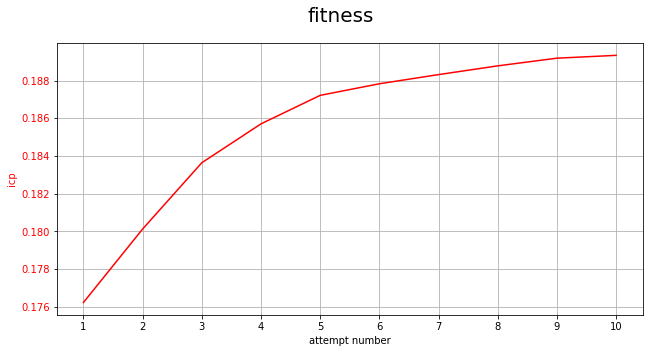

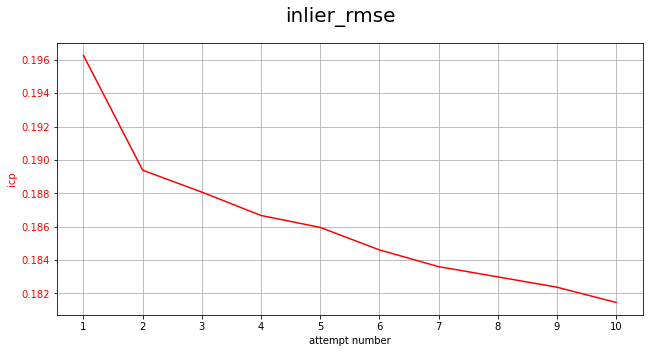

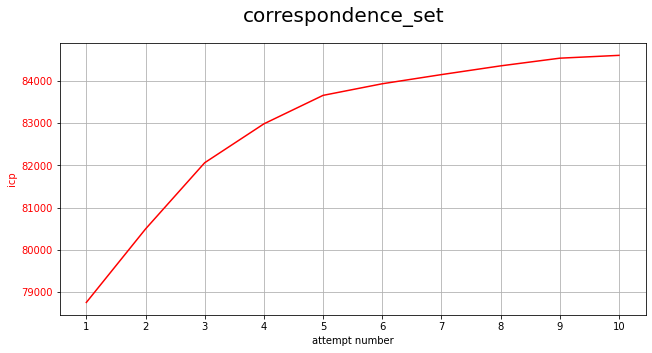

In [30]:
for i in range(len(icp_parameters_labels)):
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10.5, 5)
    fig.suptitle(f'{icp_parameters_labels[i][4:-5]}', fontsize=20)
    
    ax1.set_xlabel('attempt number')
    ax1.set_ylabel('icp', color=colors[1]) 
    
    ax1.plot(x, 
             icp_parameters[i],
             colors[1],
             #colors[1]+symbols[1], 
             label=icp_parameters_labels[i]) 
    ax1.tick_params(axis='y', labelcolor=colors[1])
    ax1.set_xticks(x_label, minor=False)
    

    #ax2.legend(loc = "best")
    
    plt.grid()
    plt.show()

Both Fitness and correspondence set seem to give us an indication of where the minima that we are looking for could lie.

Looking at the last plot, "Correspondence Set".

We can observe is that despite giving the highest correspondence_set for icp registration, attempt 7 has also ne of the lowest correspondence_set for global registration.

More over most of the results of icp seem to lie sligly under 90000, while their global icp correspondence sets are in general high, but also vary between 20 and 60.

### Estimation of appropriate overlapping required

We aim to have a corrspondence set that lies in the mean.

In [24]:
from scipy import stats
print (stats.describe(icp_correspondence_set_list))
np.mean(icp_correspondence_set_list)

DescribeResult(nobs=10, minmax=(78755, 84609), mean=82956.2, variance=3845439.7333333334, skewness=-1.1725418467481121, kurtosis=0.08687294665509704)


82956.2

In [23]:
evaluated_overlapping = round(np.mean(icp_correspondence_set_list)/len(np.asarray(target.points)),2)
evaluated_overlapping

0.87

## Repeat with lower overlapping

In [24]:
i = 0
#j = 2

target_label = labels_stitches[i][9:] # just labels parsing
source_label = "stitched_seq_1_2"
target = list_stitches[i]
source = stitched_seq_1_2

start = timer()
new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= [source_label,target_label],

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 50000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**7,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = evaluated_overlapping,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = True,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

end = timer()

print ("duration:",(end-start))

stitch_stitched_seq_1_2_External

DOWNSAMPLING BIG CLOUDS

stitched_seq_1_2
Downsampling stitched_seq_1_2 from 446878 points with voxel size 0.1 
Downsampling stitched_seq_1_2 from 131859 points with voxel size 0.15 
Downsampling stitched_seq_1_2 from 68234 points with voxel size 0.2 
Processed stitched_seq_1_2 has 40232 points 

External
Downsampling External from 230502 points with voxel size 0.1 
Downsampling External from 92364 points with voxel size 0.15 
Downsampling External from 54486 points with voxel size 0.2 
Processed External has 33072 points 

DATA PREPARATION
removing outliers
value to reach:  200536.74
source has 446878 points
target has 230502 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=2.042484e-03, inlier_rmse=2.326962e-01, and correspondence_set size of 15
Access transformation to get result.

Access transformation to get result.
Transformation is:
[[  0.99822189  -0.05761479   0.01528377  -1.2549065 ]
 [  0.05551154   0.9919571    0.11375228 -13.07483516]
 [ -0.02171466  -0.11270159   0.99339158   1.40777237]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 8

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=5.174292e-03, inlier_rmse=2.216830e-01, and correspondence_set size of 38
Access transformation to get result.
Transformation is:
[[ 9.88816613e-01 -6.48012318e-02  1.34322400e-01 -6.24430455e+00]
 [ 1.16966428e-02  9.31590023e-01  3.63322471e-01 -2.35428928e+01]
 [-1.48677151e-01 -3.57688174e-01  9.21929647e-01  6.43636769e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
dis

We have got an acceptable result in one run.

[Open3D WARNING] GLFW Error: The GLFW library is not initialized


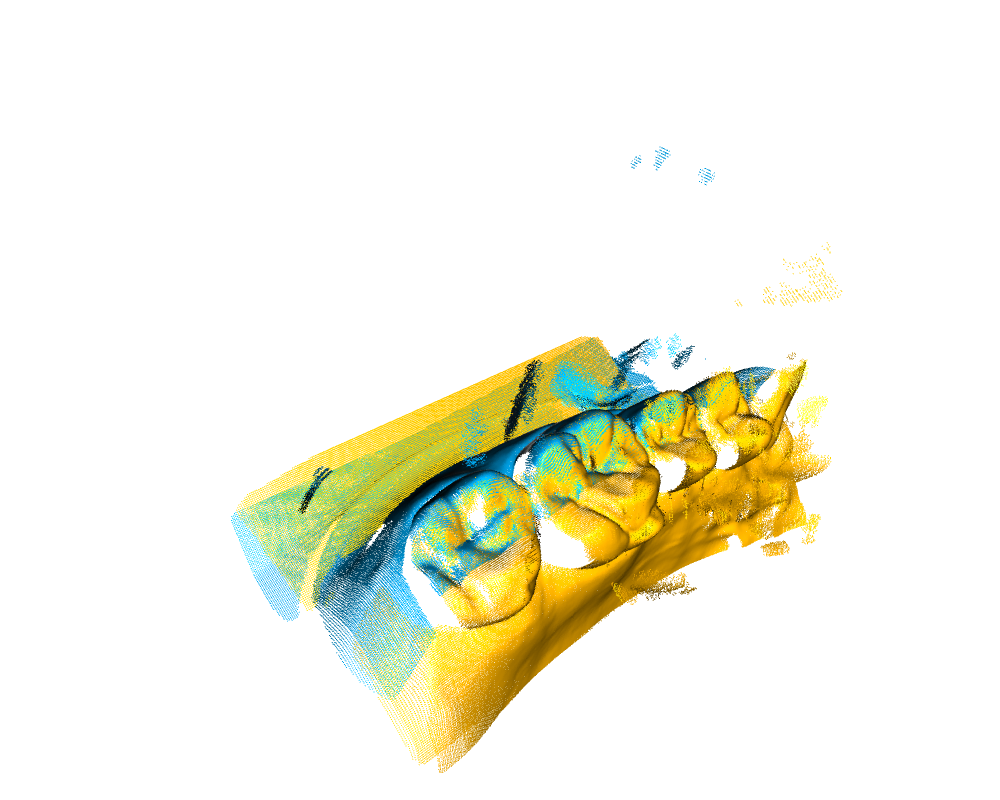

In [25]:
#o3d.visualization.draw_geometries([list_new_pointclouds[-1]])
lower_overlapping_stitched_seq_0_12 = newpointcloud
lower_overlapping_results_stitching_0_12 = all_results
tstring = mytimestamp()

custom_draw_geometry(lower_overlapping_stitched_seq_0_12,
                     mytitle = "lower_overlapping_stitched_seq_0_12",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = False,
                     rotate = "interactive")

# after manual changing in visualization mode
newest = last_file_containing("lower_overlapping_stitched_seq_0_12", extension = '.png')
Im(filename=newest,width = 800)

In [26]:
complete = lower_overlapping_stitched_seq_0_12
get_num_points([complete])

[677380]

In [27]:
#o3d.io.write_point_cloud("complete.pcd", complete)
o3d.io.write_point_cloud("../data/"+mytimestamp()+"complete.pcd", complete)

True

In [28]:
# save
complete= o3d.io.read_point_cloud("../data/"+"complete.pcd")